# **The aim is to predict the coronary heart disease (chd: 1/0) for males in a heart-disease high-risk region of the Western Cape, South Africa**

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold,  StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_sample_weight

**1. Conduct an exploratory data analysis on this dataset**

In [2]:
# Import dataset
hs= pd.read_csv('heart-disease.csv', sep=';')
hs.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [3]:
hs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    object 
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 36.2+ KB


In [4]:
# Check class distribution of the target variable (chd) 
print(hs['chd'].value_counts(normalize=True))

chd
0    0.65368
1    0.34632
Name: proportion, dtype: float64


In [5]:
# Convert famhist into dummy variable 
hs['famhist_numeric'] = hs['famhist'].map({'Present': 1, 'Absent': 0})

In [6]:
# Summary Statistics
hs.describe()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd,famhist_numeric
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.346320,0.415584
std,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.476313,0.493357
min,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000,1.000000


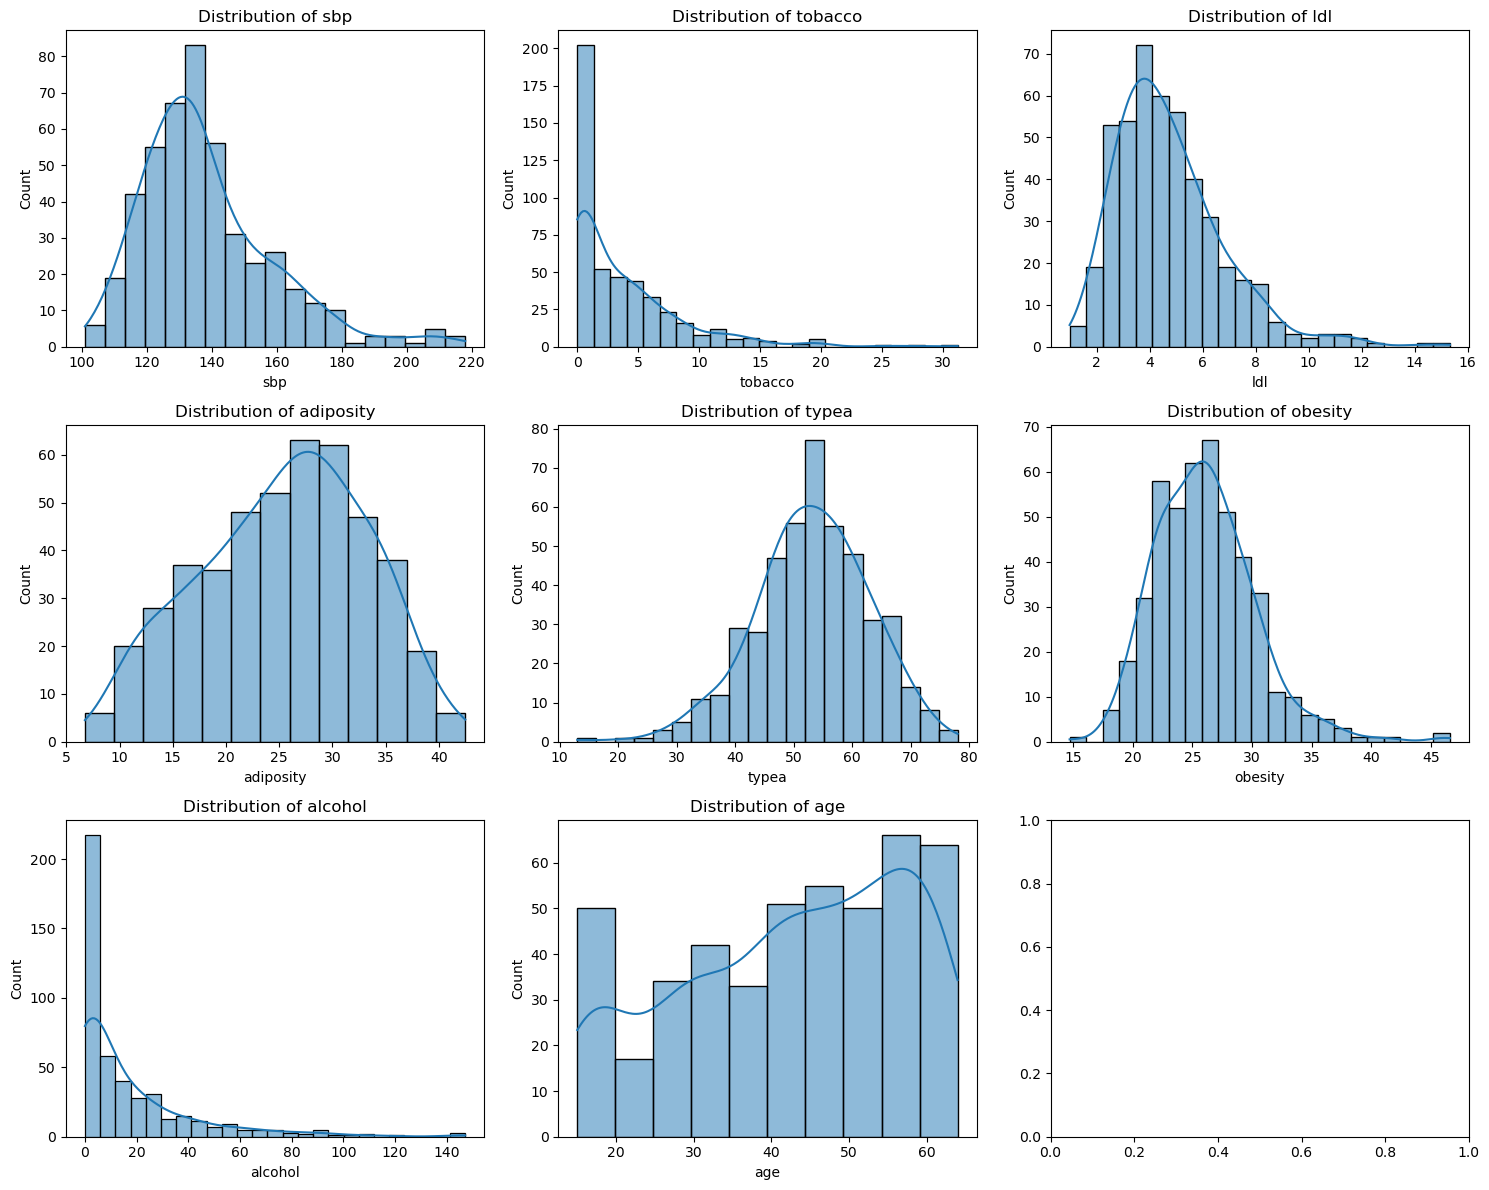

In [7]:
# Visualizing the distribution of numerical features to understand their spread, skewness, and potential outliers  

# Set up a multi-plot figure
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Plot histograms for numerical features
numerical_features = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']
for i, feature in enumerate(numerical_features):
    sns.histplot(hs[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

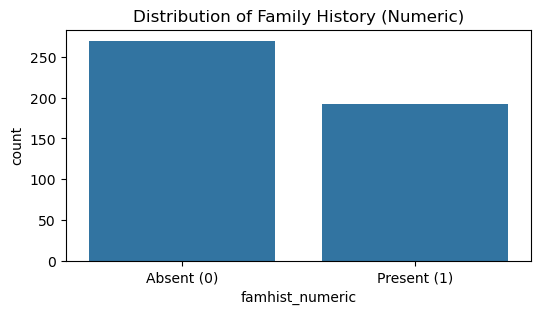

In [8]:
# Visualization for the binary famhist_numeric
plt.figure(figsize=(6, 3))
sns.countplot(x='famhist_numeric', data=hs)
plt.title('Distribution of Family History (Numeric)')
plt.xticks([0, 1], ['Absent (0)', 'Present (1)'])
plt.show()

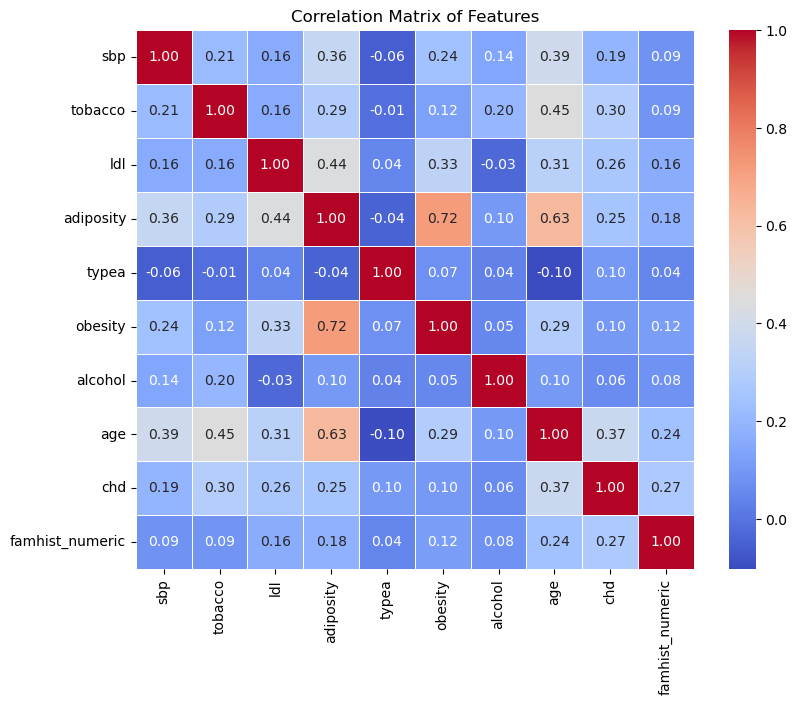

In [9]:
# Data for correlation 
corr_data = hs.drop('famhist', axis=1)  # Drop the categorical version
corr_matrix = corr_data.corr()

# Visualize correlation matrix
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

**2. Fit a logistic regression with ridge penalty to classify the patients and explain the results**

In [10]:
# Selecting features and target variable
selected_features = ['age', 'tobacco', 'famhist_numeric', 'ldl', 'adiposity', 'sbp', 'typea', 'obesity', 'alcohol']
X = hs[selected_features]
y = hs ['chd']  # Target variable

In [11]:
# Split into training (80%) and test (20%)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# SMOTE 
smote = SMOTE(random_state=42)
Xtrain_smote, ytrain_smote = smote.fit_resample(Xtrain, ytrain)

In [13]:
# Standardize Data (for models that need it: Logistic Regression, SVM, KNN)
scaler = StandardScaler()
Xtrain_scaled = pd.DataFrame(scaler.fit_transform(Xtrain), columns=Xtrain.columns)  # For class weight models
Xtrain_smote_scaled = pd.DataFrame(scaler.fit_transform(Xtrain_smote), columns=Xtrain.columns)  # For SMOTE models
Xtest_scaled = pd.DataFrame(scaler.transform(Xtest), columns=Xtest.columns)


Now lets start fitting the Logit Model with ridge penalty

In [14]:
# Define hyperparameter grid to tune 
param_grid_logit = {
    'C': [0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'solver': ['liblinear', 'saga', 'newton-cg'],  # Solvers to try
    'max_iter': [100, 200, 300]  # Number of iterations for optimization
}

In [15]:
# Initialize the Logistic Regression model without specifying hyperparameters
logit_reg = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42)

In [16]:
# Set up GridSearchCV with cross-validation to search for best parameters
grid_search_logit = GridSearchCV(logit_reg, param_grid_logit, cv=5, scoring='accuracy', n_jobs=-1)

In [17]:
# Fit GridSearchCV on the resampled training data 
grid_search_logit.fit(Xtrain_scaled, ytrain)

# Print the best hyperparameters and the corresponding accuracy
print('Best Hyperparameters:', grid_search_logit.best_params_)
print('Best Cross-Validation Accuracy:', grid_search_logit.best_score_)

Best Hyperparameters: {'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.6910403554239172


In [18]:
# Train the final model with the best parameters found during grid search
best_logit_reg = grid_search_logit.best_estimator_

In [19]:
# Evaluate the model on the test set
y_test_pred_logit = best_logit_reg.predict(Xtest_scaled)

test_accuracy = accuracy_score(ytest, y_test_pred_logit)
print('Test Accuracy:', test_accuracy)


Test Accuracy: 0.7204301075268817


In [20]:
# Confusion Matrix 
logit_conf_matrix = confusion_matrix(ytest, y_test_pred_logit)
print('Confusion Matrix:\n', logit_conf_matrix)

Confusion Matrix:
 [[44 15]
 [11 23]]


In [21]:
# Class Report
logit_class_report = classification_report(ytest, y_test_pred_logit, zero_division=1)
print('Classification Report:\n', logit_class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.77        59
           1       0.61      0.68      0.64        34

    accuracy                           0.72        93
   macro avg       0.70      0.71      0.71        93
weighted avg       0.73      0.72      0.72        93



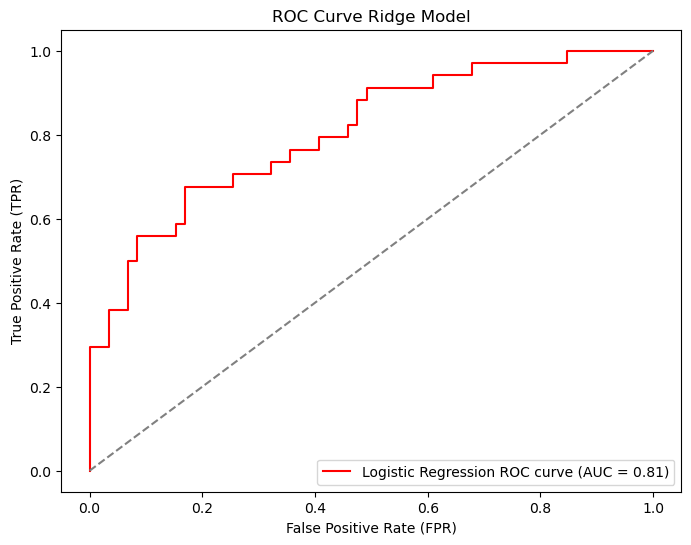

AUC for Logistic Regression: 0.81


In [22]:
# Predict probabilities (probability of CHD = 1)
y_prob_logreg = best_logit_reg.predict_proba(Xtest_scaled)[:, 1]
# Calculate ROC curve values
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(ytest, y_prob_logreg)
# Calculate AUC
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, color='red', label=f'Logistic Regression ROC curve (AUC = {roc_auc_logreg:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random model line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Ridge Model')
plt.legend(loc='lower right')
plt.show()

# Print AUC score for Logistic Regression
print(f'AUC for Logistic Regression: {roc_auc_logreg:.2f}')

**3. Explore other classifiers discussed in this module and find one that gives you the highest accuracy. Explain your procedure to achieve the final chosen classifier and discuss the results**

**3.1. Gradient Boosting Model**

In [ ]:
# In order to handle class imbalance:

# Compute sample weights for training data
sample_weights = compute_sample_weight(class_weight='balanced', y=ytrain)

# Print sample weight distribution
print("Sample Weights (first 10):", sample_weights[:10])


Sample Weights (first 10): [0.75925926 0.75925926 1.46428571 0.75925926 1.46428571 0.75925926
 1.46428571 0.75925926 0.75925926 1.46428571]


In [24]:
# Define Gradient Boosting model
grd = GradientBoostingClassifier(random_state=42)

In [25]:
# Hyperparameter tuning
param_grid_gb = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 300],
    'max_depth': [3, 4, 5]
}

In [26]:
# Perform Grid Search with cross-validation 
grid_search_gb = GridSearchCV(grd, param_grid_gb, cv=10, scoring='accuracy', n_jobs=-1)

In [27]:
# Train the model using sample weights instead of SMOTE
grid_search_gb.fit(Xtrain, ytrain, sample_weight=sample_weights)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, 5],
                         'n_estimators': [100, 300]},
             scoring='accuracy')

In [28]:
# Print best parameters
print('Best Parameters:', grid_search_gb.best_params_)
print('Best Cross-Validation Accuracy:', grid_search_gb.best_score_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.6831081081081081


In [29]:
# Get best model
best_grd = grid_search_gb.best_estimator_

# Evaluate model on the Test Set 
y_pred_test_gb = best_grd.predict(Xtest)

In [30]:
# Compute test accuracy
test_accuracy = accuracy_score(ytest, y_pred_test_gb)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.7312


In [31]:
# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(ytest, y_pred_test_gb))


Confusion Matrix:
[[44 15]
 [10 24]]


In [32]:
# Classification Report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(ytest, y_pred_test_gb))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        59
           1       0.62      0.71      0.66        34

    accuracy                           0.73        93
   macro avg       0.72      0.73      0.72        93
weighted avg       0.74      0.73      0.73        93



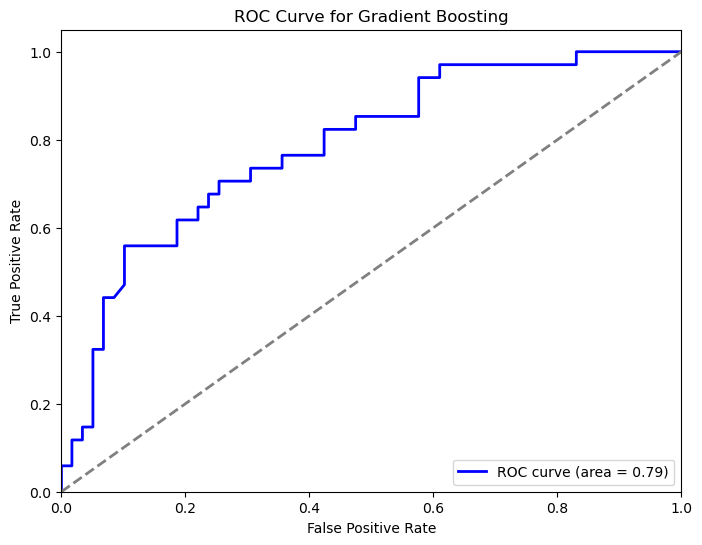

In [33]:
# ROC Curve
y_test_prob_gb =best_grd.predict_proba(Xtest)[:, 1]
fpr, tpr, _ = roc_curve(ytest, y_test_prob_gb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting')
plt.legend(loc="lower right")
plt.show()



**3.2. Random Forest Model**

In [34]:
# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

In [35]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],    
    'max_features': ['sqrt', 'log2', None],  
    'bootstrap': [True, False]       
}

In [36]:
# Create a k-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [37]:
# Due to the large parameter space, we use RandomizedSearchCV instead of GridSearchCV
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_grid_rf,  n_iter=30, cv=cv, scoring='accuracy', n_jobs=-1,verbose=1,
random_state=42)

In [38]:
# Train the model on training data
random_search_rf.fit(Xtrain, ytrain) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='accuracy', verbose=1)

In [39]:
# Print best parameters and score
print('Best Parameters:', random_search_rf.best_params_)
print('Best Cross-Validation Accuracy:', random_search_rf.best_score_)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Best Cross-Validation Accuracy: 0.6935209181784524


In [40]:
# Get the best model
best_rf = random_search_rf.best_estimator_
# Evaluate on test set
y_pred_rf = best_rf.predict(Xtest)  

In [41]:
# Accuracy
rf_accuracy = accuracy_score(ytest, y_pred_rf)
print(f'Final Test Accuracy (Random Forest): {rf_accuracy:.4f}')

Final Test Accuracy (Random Forest): 0.7527


In [42]:
# Confusion Matrix
print('\nConfusion Matrix:\n', confusion_matrix(ytest, y_pred_rf))


Confusion Matrix:
 [[49 10]
 [13 21]]


In [43]:
# Classification Report
print('\nSVM Classification Report:')
print(classification_report(ytest, y_pred_rf))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        59
           1       0.68      0.62      0.65        34

    accuracy                           0.75        93
   macro avg       0.73      0.72      0.73        93
weighted avg       0.75      0.75      0.75        93



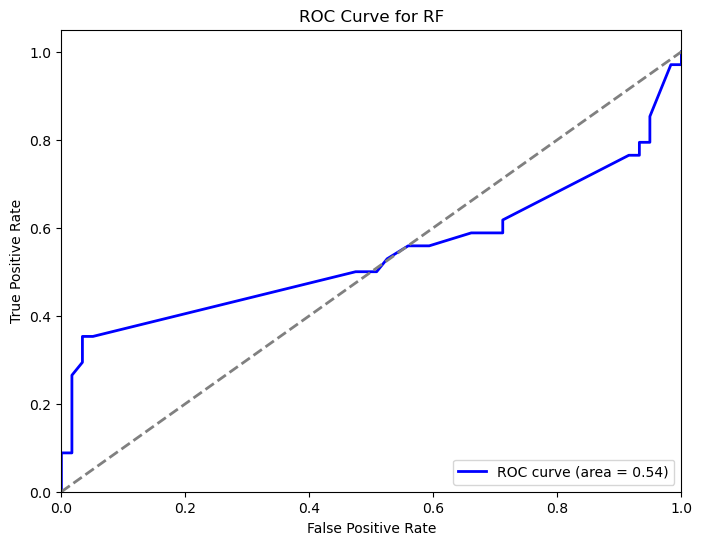

In [44]:
# ROC curve
y_proba_rf = best_rf.predict_proba(Xtest_scaled)[:, 1]
fpr, tpr, _ = roc_curve(ytest, y_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RF')
plt.legend(loc="lower right")
plt.show()

**3.3.Linear Discrimination Analysis (LDA) Model**

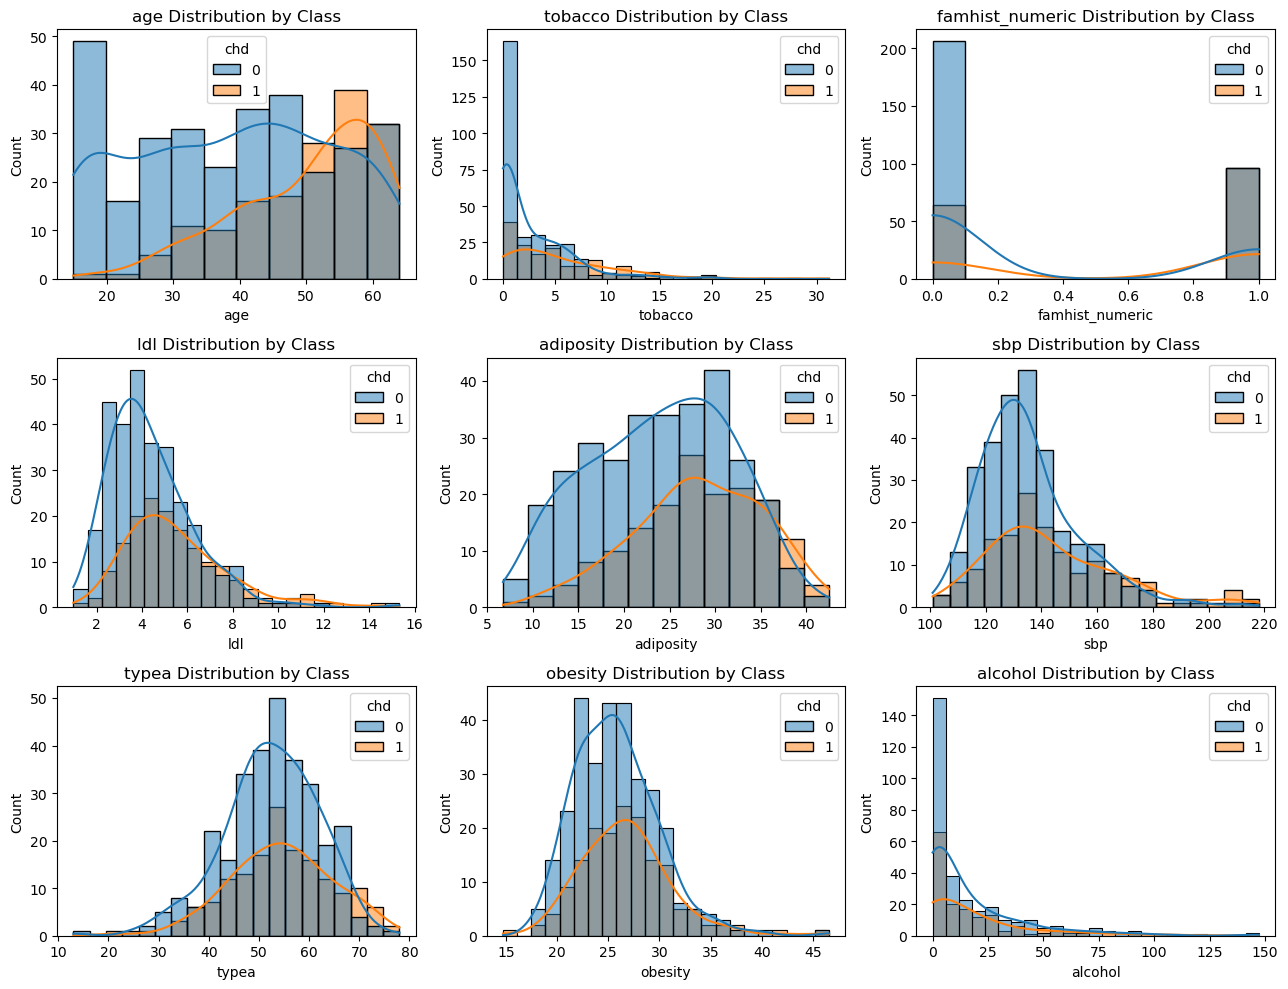

In [45]:
# Visualize feature distribution by class
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    sns.histplot(data=hs, x=feature, hue='chd', kde=True, ax=axes[i])
    axes[i].set_title(f'{feature} Distribution by Class')

plt.tight_layout()
plt.show()

* Most variables show some degree of class separation but with substantial overlap
* Several features (tobacco, alcohol) show right-skewed rather than normal distributions
* Age show the clearest separation between classes

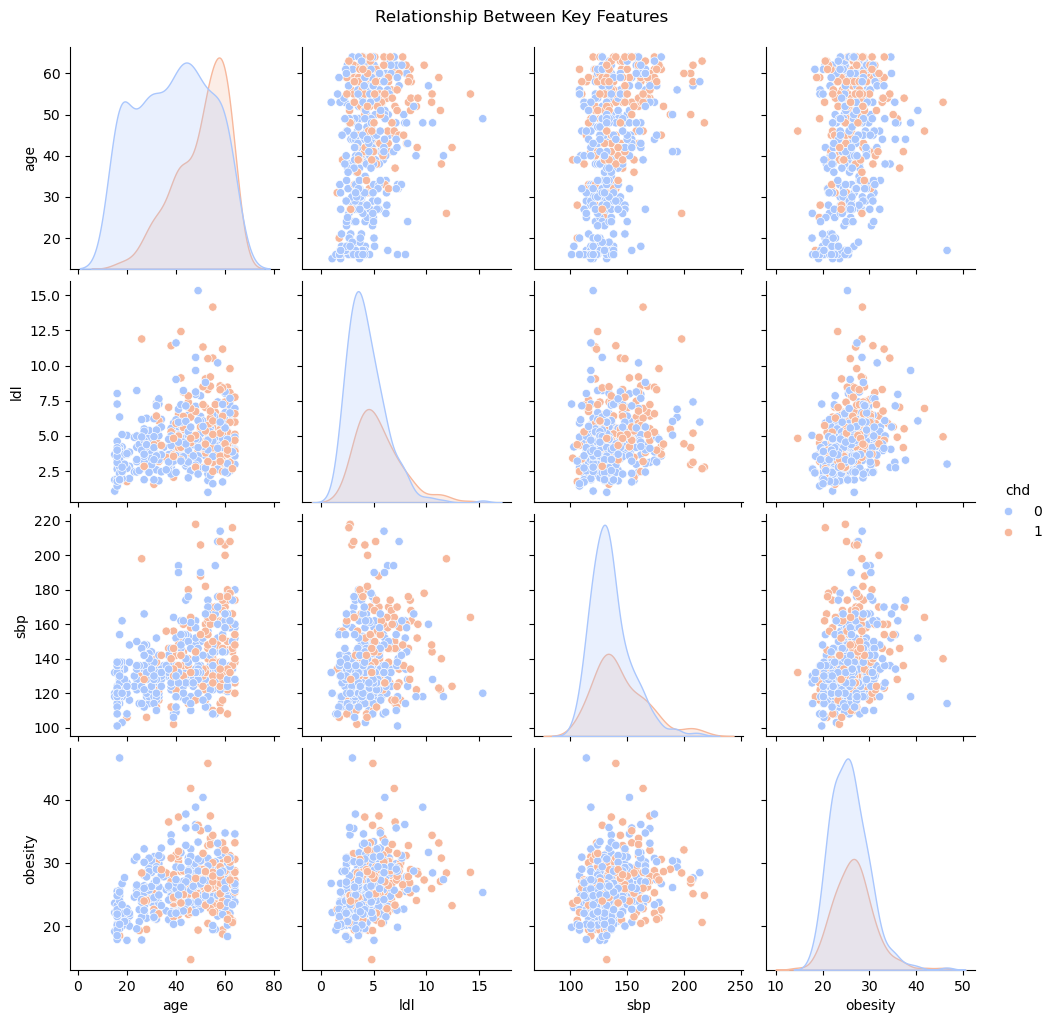

In [46]:
# Create pairplots for feature relationships colored by target
# Select a subset of features if the plot gets too busy
subset_features = ['age', 'ldl', 'sbp', 'obesity']  # Choose most important ones
sns.pairplot(hs[subset_features + ['chd']], hue='chd', palette='coolwarm')
plt.suptitle('Relationship Between Key Features', y=1.02)
plt.show()

* The classes are not cleanly separable by straight lines in any of the projections
* There appear to be more complex, potentially nonlinear relationships between features
* The variance/covariance structure appears somewhat different between the two classes
* Age shows the most visible separation between classes, with CHD cases generally shifted toward higher ages
* There are some outliers in features like SBP and LDL that might influence modeling


In [47]:
# Fit LDA model
lda = LinearDiscriminantAnalysis()

In [48]:
# Hyperparameter Tuning 
param_grid_lda = {
    'solver': ['lsqr'],  # SVD does not support shrinkage, so we use 'lsqr'
    'shrinkage': [None, 0.1, 0.3, 0.5, 0.7, 0.9]  # Test different shrinkage values
}

In [49]:
# Use Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [50]:
# Grid search for best parameters
grid_search_lda = GridSearchCV(lda, param_grid_lda, cv=cv, n_jobs=-1)

In [51]:
# Train Model
grid_search_lda.fit(Xtrain_scaled, ytrain)

# Print best parameters and accuracy
print('Best Parameters:', grid_search_lda.best_params_)
print('Best Cross-Validation Accuracy:', grid_search_lda.best_score_)

Best Parameters: {'shrinkage': 0.3, 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.7207330618289522


In [52]:
# Final evaluation on test set
best_lda= grid_search_lda.best_estimator_
y_test_pred_lda = best_lda.predict(Xtest_scaled)

In [53]:
test_accuracy = accuracy_score(ytest, y_test_pred_lda)

print('Final Test Accuracy:', test_accuracy)

Final Test Accuracy: 0.7526881720430108


In [54]:
# Confusion Matrix
print('\nConfusion Matrix:\n', confusion_matrix(ytest, y_test_pred_lda))


Confusion Matrix:
 [[51  8]
 [15 19]]


In [55]:
# Class Report
lda_class_report = classification_report(ytest, y_test_pred_lda, zero_division=1)
print('Classification Report:\n', lda_class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.82        59
           1       0.70      0.56      0.62        34

    accuracy                           0.75        93
   macro avg       0.74      0.71      0.72        93
weighted avg       0.75      0.75      0.75        93



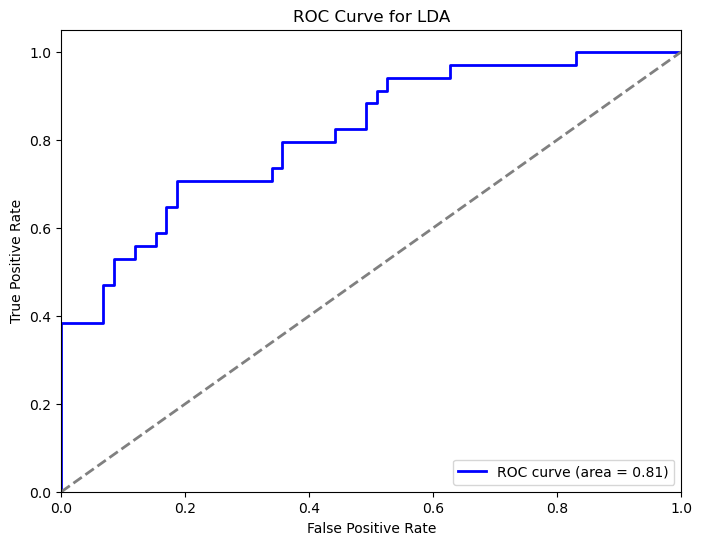

In [56]:
# ROC curve
y_test_prob_lda = best_lda.predict_proba(Xtest_scaled)[:, 1]
fpr, tpr, _ = roc_curve(ytest, y_test_prob_lda)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LDA')
plt.legend(loc="lower right")
plt.show()

**3.4. Support Vector Machines (SVM) Model**

In [57]:
# Create an SVM classifier
svm = SVC(probability=True,class_weight='balanced',random_state=42)  

In [58]:
# Define the parameter grid for SVM
param_grid_svm = [
    {'C': [0.1, 1, 10, 100], 'kernel': ['linear'], 'shrinking': [True, False]},
    {'C': [0.1, 1, 10, 100], 'kernel': ['rbf'], 'gamma': ['scale', 'auto'], 'shrinking': [True, False]},
    {'C': [0.1, 1, 10, 100], 'kernel': ['poly'], 'gamma': ['scale', 'auto'], 'degree': [3, 4, 5], 'shrinking': [True, False]},
    ]

In [59]:
# Create a stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [77]:
# Set up GridSearchCV
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=cv,n_jobs=-1, scoring='accuracy',verbose=1)

In [78]:
# Train the model on scaled data
grid_search_svm.fit(Xtrain_scaled, ytrain) 
# Print best parameters and score
print('Best Parameters:', grid_search_svm.best_params_)
print('Best Cross-Validation Accuracy:', grid_search_svm.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'C': 0.1, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'shrinking': True}
Best Cross-Validation Accuracy: 0.7181044057756387


In [62]:
# Get the best model
best_svm = grid_search_svm.best_estimator_
# Evaluate on test set
y_pred_svm = best_svm.predict(Xtest_scaled)


In [63]:
# Accuracy
svm_accuracy = accuracy_score(ytest, y_pred_svm)
print(f'Final Test Accuracy (SVM): {svm_accuracy:.4f}')

Final Test Accuracy (SVM): 0.7527


In [64]:
# Confusion Matrix
print('\nConfusion Matrix:\n', confusion_matrix(ytest, y_pred_svm))


Confusion Matrix:
 [[50  9]
 [14 20]]


In [65]:
# Classification Report
print('\nSVM Classification Report:')
print(classification_report(ytest, y_pred_svm))



SVM Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81        59
           1       0.69      0.59      0.63        34

    accuracy                           0.75        93
   macro avg       0.74      0.72      0.72        93
weighted avg       0.75      0.75      0.75        93



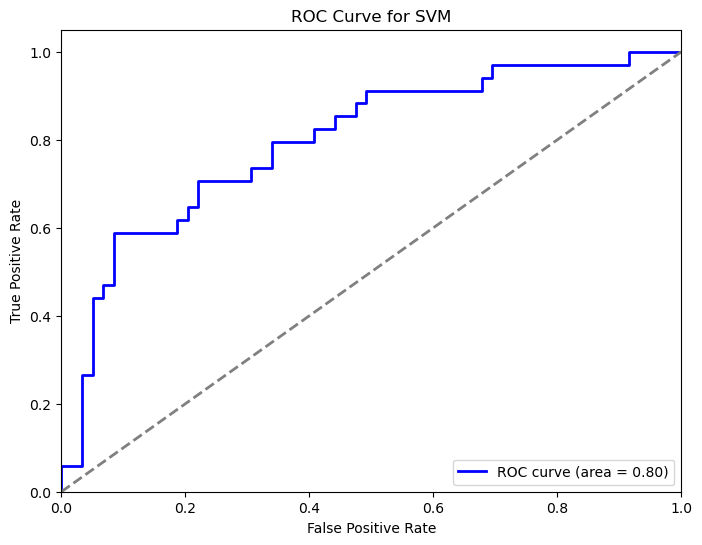

In [66]:
# ROC curve
y_test_prob_svm = best_svm.predict_proba(Xtest_scaled)[:, 1]
fpr, tpr, _ = roc_curve(ytest, y_test_prob_svm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.legend(loc="lower right")
plt.show()

**3.5. QDA Model**

In [67]:
qda = QuadraticDiscriminantAnalysis()

In [68]:
# Perform 5-fold cross-validation on the training data
qda_cv_scores = cross_val_score(qda, Xtrain_scaled, ytrain, cv=5)

# Print results
print(f'QDA Cross-validation scores: {qda_cv_scores}')
print(f'QDA Mean Cross-validation score: {qda_cv_scores.mean()}')

QDA Cross-validation scores: [0.7027027  0.74324324 0.68918919 0.66216216 0.7260274 ]
QDA Mean Cross-validation score: 0.7046649389115143


In [69]:
# Train the best model on the training set
qda.fit(Xtrain_scaled, ytrain)

QuadraticDiscriminantAnalysis()

In [70]:
# Make predictions on the test set
y_pred_qda = qda.predict(Xtest_scaled)

In [71]:
# Get Accuracy
qda_accuracy = accuracy_score(ytest, y_pred_qda)
print(f'\nQDA Accuracy: {qda_accuracy:.4f}')


QDA Accuracy: 0.7527


In [72]:
# Confusion Matrix 
print('\nConfusion Matrix:\n', confusion_matrix(ytest, y_pred_qda))


Confusion Matrix:
 [[52  7]
 [16 18]]


In [73]:
# Classification Report
print('QDA Classification Report:\n', classification_report(ytest, y_pred_qda))

QDA Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.82        59
           1       0.72      0.53      0.61        34

    accuracy                           0.75        93
   macro avg       0.74      0.71      0.71        93
weighted avg       0.75      0.75      0.74        93



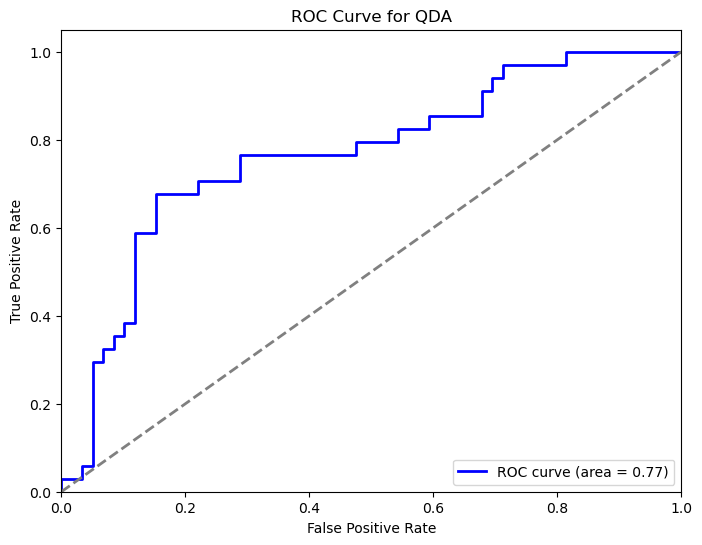

In [74]:
# ROC curve
y_proba_qda = qda.predict_proba(Xtest_scaled)[:, 1]
fpr, tpr, _ = roc_curve(ytest, y_proba_qda)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for QDA')
plt.legend(loc="lower right")
plt.show()